In [243]:
#! pip install --quiet gensim
from sklearn.linear_model import LogisticRegression
import re
from re import sub, split
import seaborn as sns
import spacy
import pandas as pd
import matplotlib.pyplot as plt

In [55]:
yelps = pd.read_csv('sentiment/yelps.csv').sample(frac=1).reset_index(drop=True)

In [56]:
from bs4 import BeautifulSoup

def clean_yelp(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

def tokenize(s):
    """ Returns a list of strings (tokens) from the document """    
    re_pattern = r"(?u)\b\w\w+\b"
    token_pattern = re.compile(re_pattern)
    return  token_pattern.findall(s) 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

count_vectorizer = CountVectorizer(preprocessor = clean_yelp, tokenizer = tokenize)
TF_matrix = count_vectorizer.fit_transform(yelps.text)

embedding = TruncatedSVD(n_components = 100)
term_embedding_matrix  = embedding.fit_transform(TF_matrix)

In [66]:
print("TF Matrix: " + str(TF_matrix.shape) + "\nTerm Embedding Matrix: " 
      + str(term_embedding_matrix.shape))

TF Matrix: (100000, 78364)
Term Embedding Matrix: (100000, 100)


In [58]:
from sklearn.metrics import accuracy_score

def test_holdout_vectors(V, y, cutoff):
    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    model.fit(V[:cutoff], y[:cutoff])
    preds = model.predict(V[cutoff:])
    return accuracy_score(preds, y[cutoff:])

In [61]:
# Test your vector representations using the above function, test_holdout_vectors. 
# for several levels of "cutoff". 

# This function simulates training on a small part of your data and testing on the rest.
# Thus, it's as though you have some labelled data but a bunch of unlabelled data. 
# This is essentially a semi-supervised situation. 

# Do the word embeddings generated via SVD allow you to pull information from the 
# unlabeled data and improve your score given a small training set? 

cutoffs = np.arange(500,50000,step = 500)
tf = [test_holdout_vectors(TF_matrix, yelps.positive, cuts) for cuts in cutoffs]
embeded = [test_holdout_vectors(term_embedding_matrix, yelps.positive, cuts) for cuts in cutoffs]

Text(0.5, 0, 'Number of Training Observations Used (i.e. cutoff)')

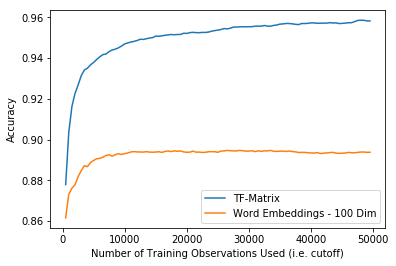

In [79]:
plt.plot(cutoffs, tf)
plt.plot(cutoffs, embeded)
plt.legend(["TF-Matrix", "Word Embeddings - 100 Dim"])
plt.ylabel('Accuracy')
plt.xlabel('Number of Training Observations Used (i.e. cutoff)')

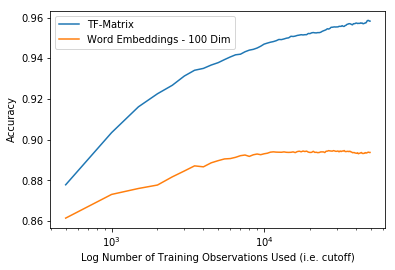

In [80]:
plt.plot(cutoffs, tf)
plt.plot(cutoffs, embeded)
plt.legend(["TF-Matrix", "Word Embeddings - 100 Dim", "Gensim word2vec"])
plt.ylabel('Accuracy')
plt.xlabel('Log Number of Training Observations Used (i.e. cutoff)')
plt.xscale("log")

In [92]:
from gensim.models import Word2Vec

# Next, create another term embedding via Word2Vec, also 100 dimensional
# Look at the documentation from the library gensim and see what hyperparameters
# you can choose to tune. 
# Note: training takes time, so you probably won't want to try too many!

# pass the cleaned and tokenized yelp reviews as "sentences" to your model
# to build the vocabulary and train the word vectors. 

# Parameters:
# - sentences: The sentences iterable can be simply a list of lists of tokens 
# - size: Dimensionality of the word vectors
# - window: Maximum distance between the current and predicted word within a sentence.
# - min_count:  Ignores all words with total frequency lower than this.
# - workers: Use these many worker threads to train the model (=faster training with multicore machines).
# - sg: Training algorithm: 1 for skip-gram; otherwise CBOW.

sentences = yelps.text.apply(clean_yelp).apply(tokenize)
model_1 = Word2Vec(sentences = sentences, size = 100, window = 5, min_count = 10, workers = 4, sg = 0)
model_2 = Word2Vec(sentences = sentences, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)
model_3 = Word2Vec(sentences = sentences, size = 100, window = 5, min_count = 10, workers = 4, sg = 1)
model_4 = Word2Vec(sentences = sentences, size = 100, window = 5, min_count = 5, workers = 4, sg = 1)

In [8]:
# use the embed_w2v function to embed your Yelp reviews using the new
# word2vec word embeddings. Each review will be a normalized sum of the
# words that it is made of. 
# See how this improves the scores in the classification task using
# test_holdout_vectors -- is word2vec better? At what training-set sizes does it help
# more? 

In [94]:
import numpy as np

def embed_w2v(tokens, w2v):
    idxs = [w2v.wv.vocab.get(t) for t in tokens]
    idxs = [t.index for t in idxs if t]
    N = w2v.wv.vectors.shape[1]
    if len(idxs) < 1:
        return np.zeros(N)
    a = np.sum(w2v.wv.vectors[idxs, :], axis=0)
    a /= np.linalg.norm(a)
    return a

In [95]:
word2vec_embeddings_1 = np.array([embed_w2v(t, model_1) for t in sentences])
embed_w2v_1 = [test_holdout_vectors(word2vec_embeddings_1, yelps.positive ,cuts) for cuts in cutoffs]

word2vec_embeddings_2 = np.array([embed_w2v(t, model_2) for t in sentences])
embed_w2v_2 = [test_holdout_vectors(word2vec_embeddings_2, yelps.positive ,cuts) for cuts in cutoffs]

word2vec_embeddings_3 = np.array([embed_w2v(t, model_3) for t in sentences])
embed_w2v_3 = [test_holdout_vectors(word2vec_embeddings_3, yelps.positive ,cuts) for cuts in cutoffs]

word2vec_embeddings_4 = np.array([embed_w2v(t, model_4) for t in sentences])
embed_w2v_4 = [test_holdout_vectors(word2vec_embeddings_4, yelps.positive ,cuts) for cuts in cutoffs]

Text(0.5, 0, 'Number of Training Observations Used (i.e. cutoff)')

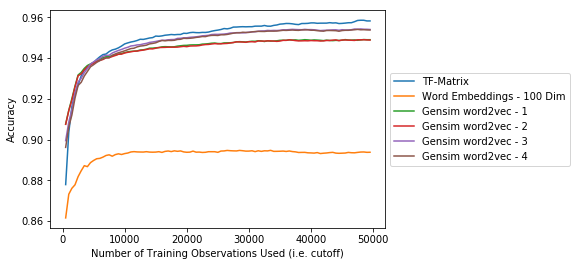

In [101]:
plt.plot(cutoffs, tf)
plt.plot(cutoffs, embeded)
plt.plot(cutoffs, embed_w2v_1)
plt.plot(cutoffs, embed_w2v_2)
plt.plot(cutoffs, embed_w2v_3)
plt.plot(cutoffs, embed_w2v_4)
plt.legend(["TF-Matrix", 
            "Word Embeddings - 100 Dim", 
            "Gensim word2vec - 1", 
            "Gensim word2vec - 2", 
            "Gensim word2vec - 3", 
            "Gensim word2vec - 4" ],loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Accuracy')
plt.xlabel('Number of Training Observations Used (i.e. cutoff)')

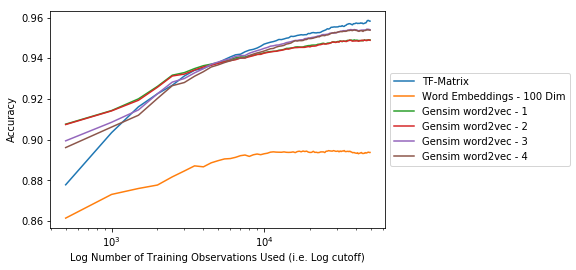

In [234]:
plt.plot(cutoffs, tf)
plt.plot(cutoffs, embeded)
plt.plot(cutoffs, embed_w2v_1)
plt.plot(cutoffs, embed_w2v_2)
plt.plot(cutoffs, embed_w2v_3)
plt.plot(cutoffs, embed_w2v_4)
plt.legend(["TF-Matrix", 
            "Word Embeddings - 100 Dim", 
            "Gensim word2vec - 1", 
            "Gensim word2vec - 2", 
            "Gensim word2vec - 3", 
            "Gensim word2vec - 4" ],loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Accuracy')
plt.xlabel('Log Number of Training Observations Used (i.e. Log cutoff)')
plt.xscale("log")

- As expected, the full model (TF-Matrix) has the best accuracy when the training set is large (above $log(10^{3.5})$), and accuracy increases marginally as the training set increases. However, word embeddings generated via SVD don't seem to allow one to pull information from the unlabeled data and improve your score given a small training set. Nevertheless, word2vec clearly outperforms the SVD - and for smaller training sets, outperforms the full model as well (below $log(10^{3.5})$).

In [142]:
import pandas as pd
import re
from functools import reduce
import emoji

pats = [re.compile(r'https?:\/\/[^\s]+'), 
        re.compile(r'rt\s*@\w+\s?:?'),
        re.compile(r'@\w+')]

def clean_twitter(s):
    """ Cleans Twitter specific issues
    
    Should probably clean out mentions, URLs, and RT's.
    """
    s = s.lower()
    _sub = lambda s,pat: re.sub(pat, '', s)
    s = reduce(_sub, pats, s)
    s = ' '.join(s.split()).strip()
    # TODO: Use regular expressions to remove unwanted
    # text and clean up our tweets to be more usable!
    # TODO: Use regular expressions to remove unwanted
    # text and clean up our tweets to be more usable!
    s = sub('@\w+','', s) 
    s = sub(' +', ' ',s)
    s = sub('#','', s) 
    s = sub("%", " percent", s) 
    s = sub('https\S+','',s) 
    s = sub('RT','',s) 
    s = sub('\n','',s) 
    s = sub('[^\w\s]','',s) 
    #s = s.encode('ascii', 'ignore').decode('ascii')
    s = emoji.demojize(s) # Convergt Emoji to text
    s = sub("&amp;", "and",s)
    return s

In [202]:
# Load tweet!
# NOTE: this file needs to be downloaded from Box! 
with open('tweets/tweets.txt') as f:
    tweets = pd.Series(f.readlines())

In [204]:
# Now embed this twitter data, again using Word2Vec and LSA (SVD)
# you don't have any labels, but you might be able to 
# find some interesting phenomena. 
count_vectorizer_twitter = CountVectorizer(preprocessor = clean_twitter, tokenizer = tokenize)
TF_matrix_twitter = count_vectorizer_twitter.fit_transform(tweets)

embedding_twitter = TruncatedSVD(n_components = 100)
term_embedding_matrix_twitter  = embedding_twitter.fit_transform(TF_matrix_twitter)
# Bonus: build a similar feature for your LSA features and
# see if you can do similar vector math

In [205]:
sentences_twitter = [clean_twitter(t).split(' ') for t in tweets]
model_twitter = Word2Vec(sentences = sentences_twitter, size = 500, window = 5, min_count = 10, workers = 4, sg = 1)
word2vec_embeddings_twitter = np.array([embed_w2v(t, model_twitter) for t in sentences_twitter])

In [206]:
# Explore using either or both of the following tools: 
# 1. Word2Vec has a built in feature for getting most similar
# words, including via positive/negative examples (subtraction)
# What happens when you subtract "hillary" from "trump"? 
display(model_twitter.wv.most_similar('trump',  topn = 5))
display(model_twitter.wv.most_similar('hillary',  topn = 5))
display(model_twitter.wv.most_similar(positive=['trump'], negative=['hillary'], topn = 5))
display(model_twitter.wv.most_similar(positive=['hillary'], negative=['trump'], topn = 5))

[('trum', 0.5641739368438721),
 ('donalds', 0.5542378425598145),
 ('mexicanamerican', 0.5465747117996216),
 ('tusk', 0.5421266555786133),
 ('vicente', 0.5416605472564697)]

[('hilary', 0.6529223918914795),
 ('hilliary', 0.6064165830612183),
 ('hiliary', 0.593682050704956),
 ('killary', 0.5891368389129639),
 ('rodham', 0.5792704224586487)]

[('trumps', 0.2526024580001831),
 ('presidenttrump', 0.24217207729816437),
 ('trumpusa', 0.2358717918395996),
 ('trumpkimsummit', 0.2295130491256714),
 ('nobannowall', 0.2288450449705124)]

[('hillarys', 0.3078247308731079),
 ('hillaryemail', 0.30051183700561523),
 ('whitewater', 0.27753618359565735),
 ('hilliary', 0.27584272623062134),
 ('killary', 0.2754514515399933)]

In [235]:
from scipy.spatial.distance import pdist,squareform
import seaborn as sns

def visualize_dist(V, tweets, idxs):
    """ Visualize distances in heatmap

    V is the vector of embeddings 
    tweets is a list or series that converts from idx to tweet
    idxs is a list of integers that you would like to compare (<= 5 probably)
    """
    m = squareform(pdist(V[idxs], 'cosine'))
    _ = sns.heatmap(pd.DataFrame(m, columns = tweets[idxs], index= tweets[idxs]))

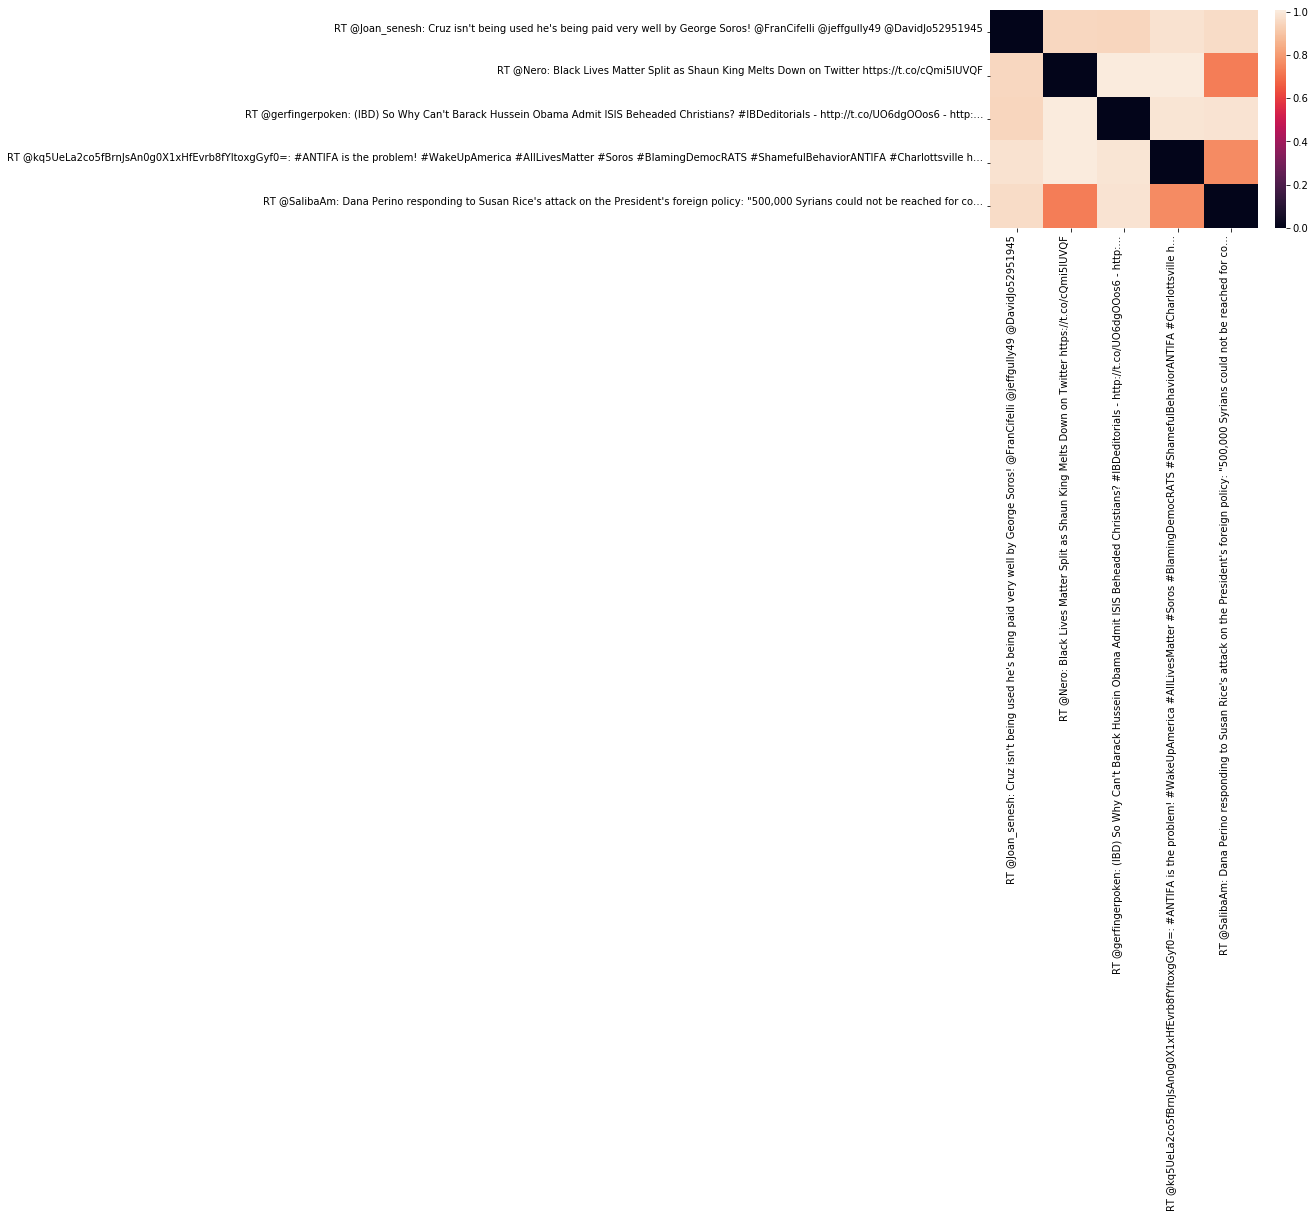

In [240]:
# 2. Use the visualize_dist function to see how
# the tweet-tweet distance looks for a selection
# of random tweets. Do you agree with the distance? 
# Does one embedding seem better than another? 
idx = np.random.randint(0, high=len(tweets), size=5)
#visualize_dist(TF_matrix_twitter, tweets, idx)
visualize_dist(term_embedding_matrix_twitter, tweets, idx)

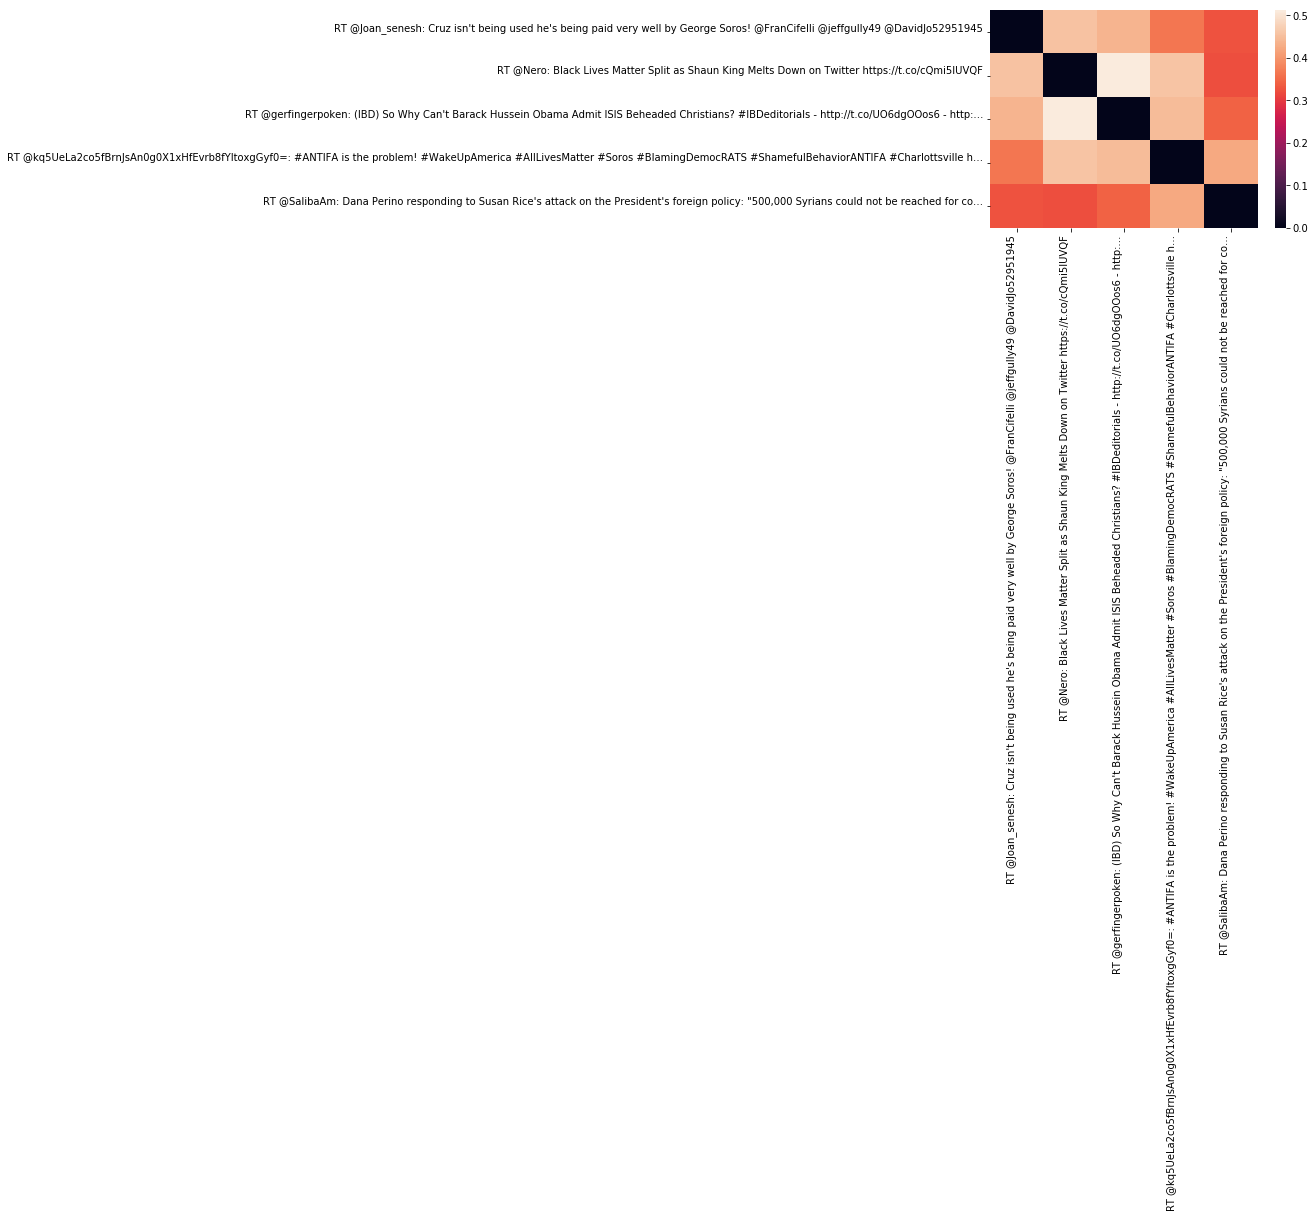

In [241]:
visualize_dist(word2vec_embeddings_twitter, tweets, idx)

The word2vec embedding seems to do a better job for most samples.

In [219]:
# More bonus!
# Use one of the following pre-embedded models and see if your yelp scores improve? 
# What about your Twitter explorations?
# https://github.com/RaRe-Technologies/gensim-data
import gensim.downloader as api

# glove-wiki-gigaword-100: Wikipedia 2014 + Gigaword 5 (6B tokens, uncased)
model_wiki = api.load("glove-wiki-gigaword-100")

[=================================================-] 99.7% 127.7/128.1MB downloaded


In [ ]:
#embed with google model
wiki_yelp = np.array([embed_w2v(t, model_wiki) for t in yelps.text.apply(clean_yelp).apply(tokenize)])
wiki_tweet = np.array([embed_w2v(t, model_wiki) for t in sentences_twitter])

In [221]:
wiki_test = [test_holdout_vectors(wiki_yelp, yelps.positive, cuts) for cuts in cutoffs]

Text(0.5, 0, 'Number of Training Observations Used (i.e. cutoff)')

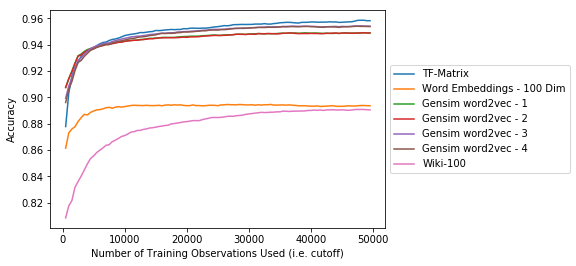

In [222]:
plt.plot(cutoffs, tf)
plt.plot(cutoffs, embeded)
plt.plot(cutoffs, embed_w2v_1)
plt.plot(cutoffs, embed_w2v_2)
plt.plot(cutoffs, embed_w2v_3)
plt.plot(cutoffs, embed_w2v_4)
plt.plot(cutoffs, wiki_test)
plt.legend(["TF-Matrix", 
            "Word Embeddings - 100 Dim", 
            "Gensim word2vec - 1", 
            "Gensim word2vec - 2", 
            "Gensim word2vec - 3", 
            "Gensim word2vec - 4",
            "Wiki-100"],loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Accuracy')
plt.xlabel('Number of Training Observations Used (i.e. cutoff)')

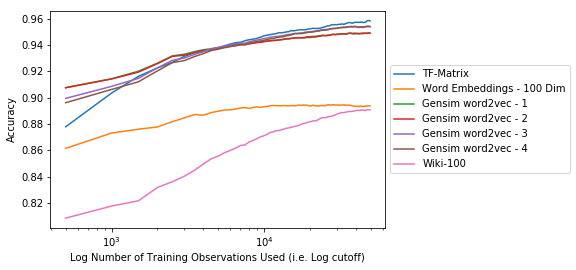

In [233]:
plt.plot(cutoffs, tf)
plt.plot(cutoffs, embeded)
plt.plot(cutoffs, embed_w2v_1)
plt.plot(cutoffs, embed_w2v_2)
plt.plot(cutoffs, embed_w2v_3)
plt.plot(cutoffs, embed_w2v_4)
plt.plot(cutoffs, wiki_test)
plt.legend(["TF-Matrix", 
            "Word Embeddings - 100 Dim", 
            "Gensim word2vec - 1", 
            "Gensim word2vec - 2", 
            "Gensim word2vec - 3", 
            "Gensim word2vec - 4",
            "Wiki-100"],loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Accuracy')
plt.xlabel('Log Number of Training Observations Used (i.e. Log cutoff)')
plt.xscale("log")

- The pretrained word2vec wiki model does not generalise well (significantly underperforms the other models), which implies that the language used to characterise the quality of restaurants (yelp) is different from the language used to in wikipedia. Nonetheless, it is also clear that the language used by wikipedia does indeed contain some information that is useful when describing the quality of restaurants (given the accuracy of ~88% - which was surprisingly good).

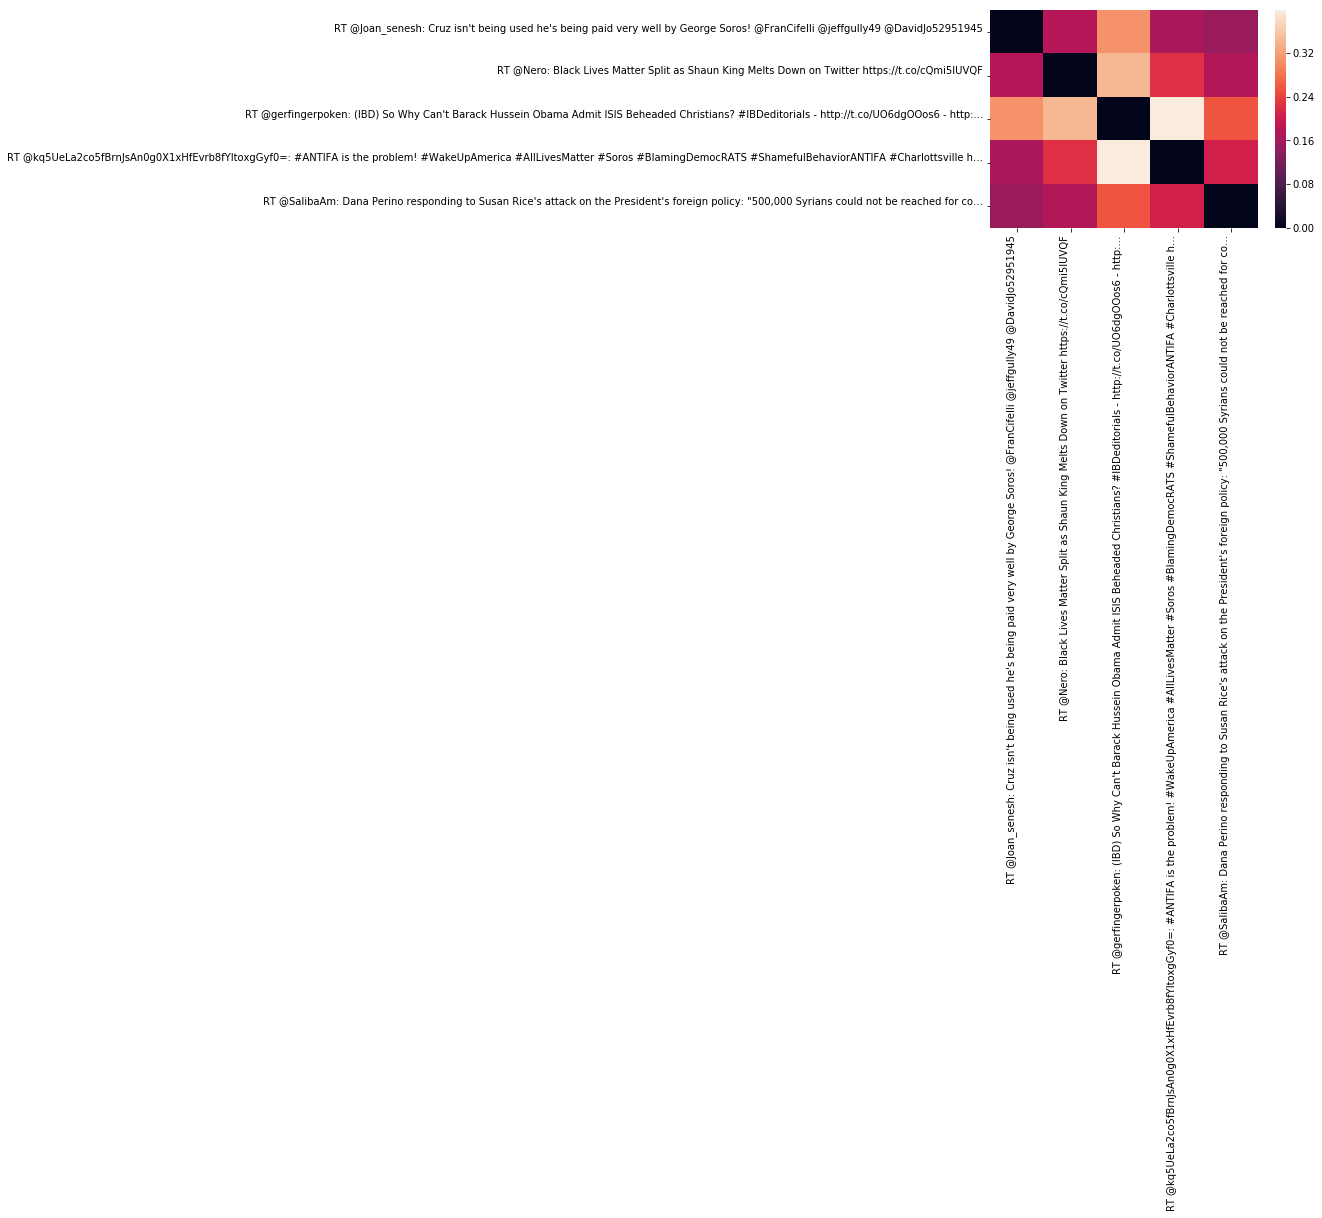

In [242]:
visualize_dist(wiki_tweet, tweets, idx)

The word2vec wiki model does not seems to do a good job

## END